In [75]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import re


In [76]:
dos_df = pd.read_csv('/kaggle/input/car-hacking-dataset/DoS_dataset.csv')
dos_df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
dos_df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [77]:
dos_df.nunique()

Timestamp    3665770
CAN ID            27
DLC                2
DATA0            108
DATA1             71
DATA2             76
DATA3             26
DATA4            190
DATA5            256
DATA6             75
DATA7            256
Flag               2
dtype: int64

In [79]:

# Convert 'Timestamp' to datetime
dos_df['Timestamp'] = pd.to_datetime(dos_df['Timestamp'], unit='ms')

# Set Timestamp as the index
dos_df = dos_df.set_index('Timestamp')
dos_df.head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,8,fe,5b,00,00,00,3c,00,00,R
1970-01-18 02:36:38.376389864,0260,8,19,21,22,30,08,8e,6d,3a,R
1970-01-18 02:36:38.376390096,02a0,8,64,00,9a,1d,97,02,bd,00,R
1970-01-18 02:36:38.376390333,0329,8,40,bb,7f,14,11,20,00,14,R
1970-01-18 02:36:38.376390574,0545,8,d8,00,00,8a,00,00,00,00,R


In [80]:
missing_values = df_2.isnull().sum()
missing_values

CAN ID        0
DLC           0
DATA0         0
DATA1         0
DATA2         0
DATA3     31188
DATA4     31188
DATA5     31188
DATA6     31188
DATA7     31188
Flag      31188
dtype: int64

In [81]:
df_dlc_is_2 = df_2[df_2["DLC"] == 2].copy()
df_dlc_is_2.head(), df_dlc_is_2.shape

(    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 35    05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 134   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 226   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 319   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 411   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN,
 (31188, 11))

In [82]:
df_d2_nan = df_2[df_2["DATA2"] == 'R'].copy()
df_d2_nan.head(), df_d2_nan.shape

(    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 35    05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 134   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 226   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 319   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 411   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN,
 (31188, 11))

In [83]:
df_flag_nan = df_2[(df_2["Flag"] != "T") & (df_2["Flag"] != "R")]
df_flag_nan.head(10), df_flag_nan.shape

(    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 35    05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 134   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 226   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 319   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 411   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 504   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 596   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 689   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 781   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 874   05f0    2    01    00     R   NaN   NaN   NaN   NaN   NaN  NaN,
 (31188, 11))

In [84]:
df_3 = df_2.copy()

In [85]:
# For rows with DLC=2, move 'R' from DATA2 to Flag
mask = df_3["DLC"] == 2
df_3.loc[mask, "Flag"] = df_3.loc[mask, "DATA2"]  # Copy 'R' to Flag
df_3.loc[mask, "DATA2"] = np.nan  # Set DATA2 to NaN for DLC=2



# Verify alignment
print(df_3[df_3["DLC"] == 2].head())

    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
35    05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN    R
134   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN    R
226   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN    R
319   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN    R
411   05f0    2    01    00   NaN   NaN   NaN   NaN   NaN   NaN    R


In [86]:
df_4 = df_3.copy()

In [87]:
# Fill NaN with hex 00
default_hex = '00'
data_columns = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df_4[data_columns] = df_4[data_columns].fillna(default_hex)
print(df_4[df_4["DLC"] == 2].head()), df_4[df_4["DLC"] == 2].shape

    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
35    05f0    2    01    00    00    00    00    00    00    00    R
134   05f0    2    01    00    00    00    00    00    00    00    R
226   05f0    2    01    00    00    00    00    00    00    00    R
319   05f0    2    01    00    00    00    00    00    00    00    R
411   05f0    2    01    00    00    00    00    00    00    00    R


(None, (31188, 11))

In [88]:
df_4.head(), df_4.shape

(  CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 0   018f    8    fe    5b    00    00    00    3c    00    00    R
 1   0260    8    19    21    22    30    08    8e    6d    3a    R
 2   02a0    8    64    00    9a    1d    97    02    bd    00    R
 3   0329    8    40    bb    7f    14    11    20    00    14    R
 4   0545    8    d8    00    00    8a    00    00    00    00    R,
 (3665770, 11))

In [89]:
df_4[(df_4["Flag"] != "T") & (df_4["Flag"] != "R")]


,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [90]:
df_4[df_4["DATA2"] == 'R'].head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [91]:
# Drop unnecessary columns
df_drop_dlc = df_4.drop(["DLC"], axis=1).copy()
df_drop_dlc.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,018f,fe,5b,00,00,00,3c,00,00,R
1,0260,19,21,22,30,08,8e,6d,3a,R
2,02a0,64,00,9a,1d,97,02,bd,00,R
3,0329,40,bb,7f,14,11,20,00,14,R
4,0545,d8,00,00,8a,00,00,00,00,R


In [92]:
df_drop_dlc.dtypes, df_drop_dlc.shape

(CAN ID    object
 DATA0     object
 DATA1     object
 DATA2     object
 DATA3     object
 DATA4     object
 DATA5     object
 DATA6     object
 DATA7     object
 Flag      object
 dtype: object,
 (3665770, 10))

In [93]:
df_can_id_0000 = df_drop_dlc[df_drop_dlc["CAN ID"] == "0000"]
df_can_id_0000.head(), df_can_id_0000.shape

(     CAN ID DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 1475   0000    00    00    00    00    00    00    00    00    T
 1477   0000    00    00    00    00    00    00    00    00    T
 1479   0000    00    00    00    00    00    00    00    00    T
 1481   0000    00    00    00    00    00    00    00    00    T
 1483   0000    00    00    00    00    00    00    00    00    T,
 (587521, 10))

In [94]:
df_6 = df_drop_dlc.copy()
df_6.describe()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3665770,3665770,3665770,3665770,3665770,3665770,3665770,3665770,3665770,3665770
unique,27,108,71,75,26,190,256,75,256,2
top,0000,00,00,00,00,00,00,00,00,R
freq,587521,1623283,1850549,2391587,1989884,1973752,1595567,2266679,2171246,3078249


In [95]:
data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# Create regex pattern for valid hex
hex_pattern = r'^[0-9A-Fa-f]{2}$'

# Check for non-hex values
mask = df_6[data_columns].apply(lambda col: ~col.str.match(hex_pattern, na=False))

# Get rows with any invalid entries
invalid_rows = df_6[mask.any(axis=1)]

print("Rows with non-hex values in DATA columns:")
print(invalid_rows if not invalid_rows.empty else "No non-hex values found")

Rows with non-hex values in DATA columns:
No non-hex values found


In [97]:
df_7 = df_6.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_7.columns[:-1]:  # Exclude 'Flag' column
    df_7[col] = df_7[col].apply(hex_to_int)

df_7.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,399,254,91,0,0,0,60,0,0,R
1,608,25,33,34,48,8,142,109,58,R
2,672,100,0,154,29,151,2,189,0,R
3,809,64,187,127,20,17,32,0,20,R
4,1349,216,0,0,138,0,0,0,0,R


In [98]:
df_8 = df_7.copy()

In [99]:
df_8["Flag"] = df_8["Flag"].map({"R": 0, "T": 1})
df_8.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,399,254,91,0,0,0,60,0,0,0
1,608,25,33,34,48,8,142,109,58,0
2,672,100,0,154,29,151,2,189,0,0
3,809,64,187,127,20,17,32,0,20,0
4,1349,216,0,0,138,0,0,0,0,0


In [100]:
df_8["Flag"].unique()

array([0, 1])

In [101]:
df_8.isna().sum()

CAN ID    0
DATA0     0
DATA1     0
DATA2     0
DATA3     0
DATA4     0
DATA5     0
DATA6     0
DATA7     0
Flag      0
dtype: int64

In [102]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665770 entries, 0 to 3665769
Data columns (total 10 columns):
 #   Column  Dtype
---  ------  -----
 0   CAN ID  int64
 1   DATA0   int64
 2   DATA1   int64
 3   DATA2   int64
 4   DATA3   int64
 5   DATA4   int64
 6   DATA5   int64
 7   DATA6   int64
 8   DATA7   int64
 9   Flag    int64
dtypes: int64(10)
memory usage: 279.7 MB


In [103]:
df_8.describe()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06,3.665770e+06
mean,5.898021e+02,5.053060e+01,3.742432e+01,3.037550e+01,5.403188e+01,3.888667e+01,5.620259e+01,2.178434e+01,4.054242e+01,1.602722e-01
std,4.309473e+02,8.810461e+01,5.212957e+01,5.307059e+01,8.843757e+01,6.810672e+01,7.704030e+01,5.247999e+01,6.740078e+01,3.668584e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.040000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.080000e+02,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.800000e+02,3.600000e+01,3.900000e+01,3.500000e+01,4.800000e+01,3.500000e+01,1.270000e+02,9.000000e+00,5.700000e+01,0.000000e+00
max,1.680000e+03,2.550000e+02,1.920000e+02,2.520000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.090000e+02,2.550000e+02,1.000000e+00


In [66]:
# df_8.to_csv('/kaggle/working/cleaned_data.csv', index=False)

# print("Data saved successfully as 'cleaned_data.csv'.")

In [107]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_8.drop(columns=['CAN ID']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
DATA0,1.000000,0.265148,-0.084861,-0.118518,0.302947,0.162191,-0.083844,-0.158038,-0.250562
DATA1,0.265148,1.000000,0.248555,0.249595,0.001412,0.275357,-0.195221,0.195102,-0.313639
DATA2,-0.084861,0.248555,1.000000,0.149292,0.367018,-0.039111,0.308908,0.133593,-0.250051
DATA3,-0.118518,0.249595,0.149292,1.000000,0.144452,0.615395,0.020012,0.038851,-0.266915
DATA4,0.302947,0.001412,0.367018,0.144452,1.000000,0.351487,0.192900,0.019239,-0.249443
DATA5,0.162191,0.275357,-0.039111,0.615395,0.351487,1.000000,0.066449,-0.032675,-0.318712
DATA6,-0.083844,-0.195221,0.308908,0.020012,0.192900,0.066449,1.000000,-0.078964,-0.181347
DATA7,-0.158038,0.195102,0.133593,0.038851,0.019239,-0.032675,-0.078964,1.000000,-0.262787
Flag,-0.250562,-0.313639,-0.250051,-0.266915,-0.249443,-0.318712,-0.181347,-0.262787,1.000000


<Axes: >

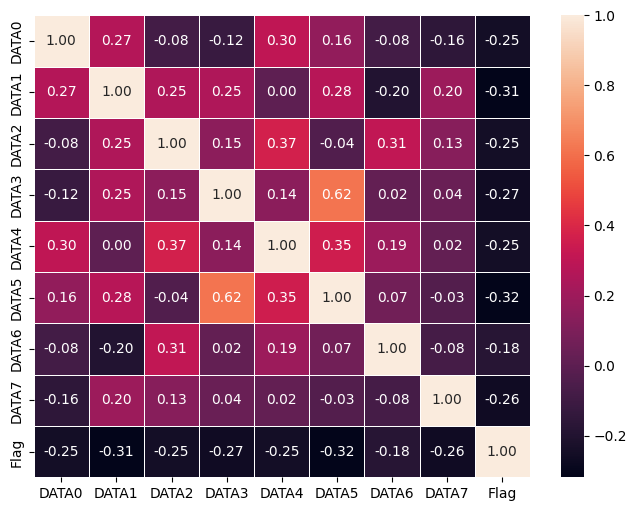

In [108]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)

In [110]:
df_9 = df_8.copy()
df_9.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,399,254,91,0,0,0,60,0,0,0
1,608,25,33,34,48,8,142,109,58,0
2,672,100,0,154,29,151,2,189,0,0
3,809,64,187,127,20,17,32,0,20,0
4,1349,216,0,0,138,0,0,0,0,0


# Realistic Scenario with no CAN ID included

## Algorithm Selection XGB

Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


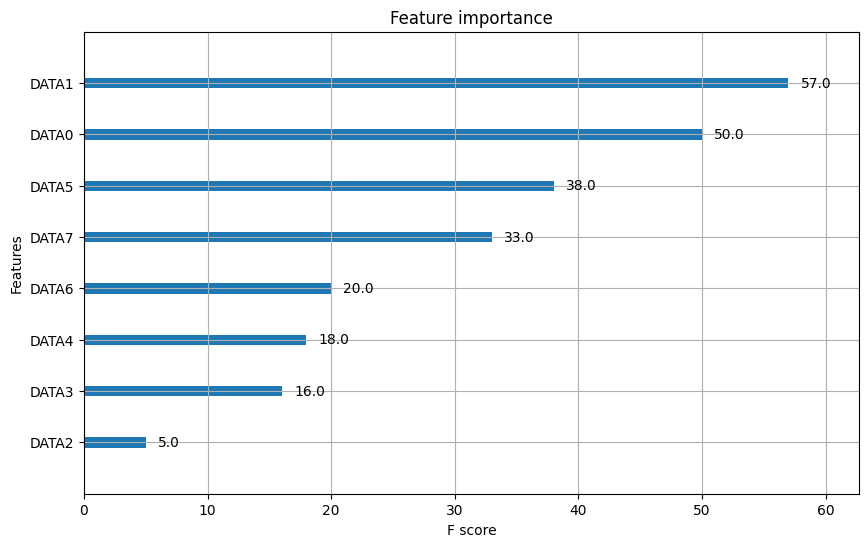

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 1. Preprocessing
# Convert CAN ID to numerical (already done as 0 for attacks)
df['CAN ID'] = df['CAN ID'].astype('int64')

# 2. Define features and target variable
# DROP CAN ID - IT'S A DIRECT LEAKAGE
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost with realistic parameters
model = xgb.XGBClassifier(
    scale_pos_weight=5.24,
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Without CAN ID Leakage)")
xgb.plot_importance(model, ax=plt.gca())
plt.show()

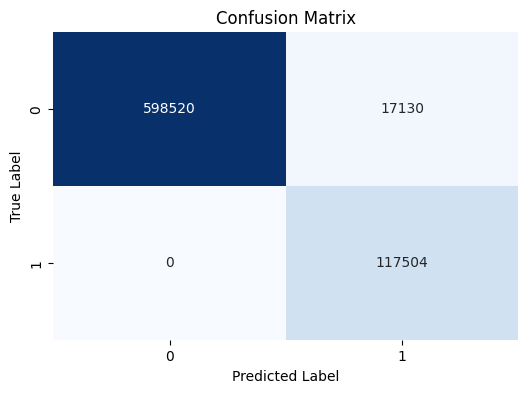

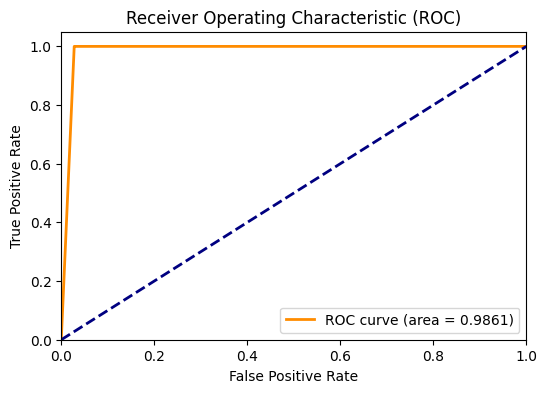

In [124]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Index(['CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6',
       'DATA7', 'Flag'],
      dtype='object')
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    615638
           1       0.87      1.00      0.93    117516

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154

ROC AUC Score: 0.9859
Optimal Decision Threshold: 0.00


<Figure size 800x500 with 0 Axes>

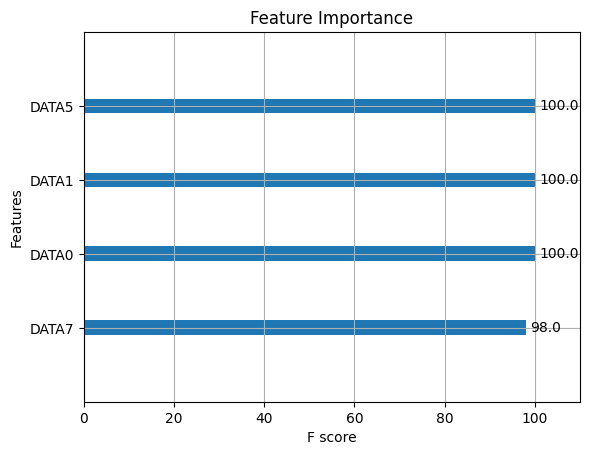

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

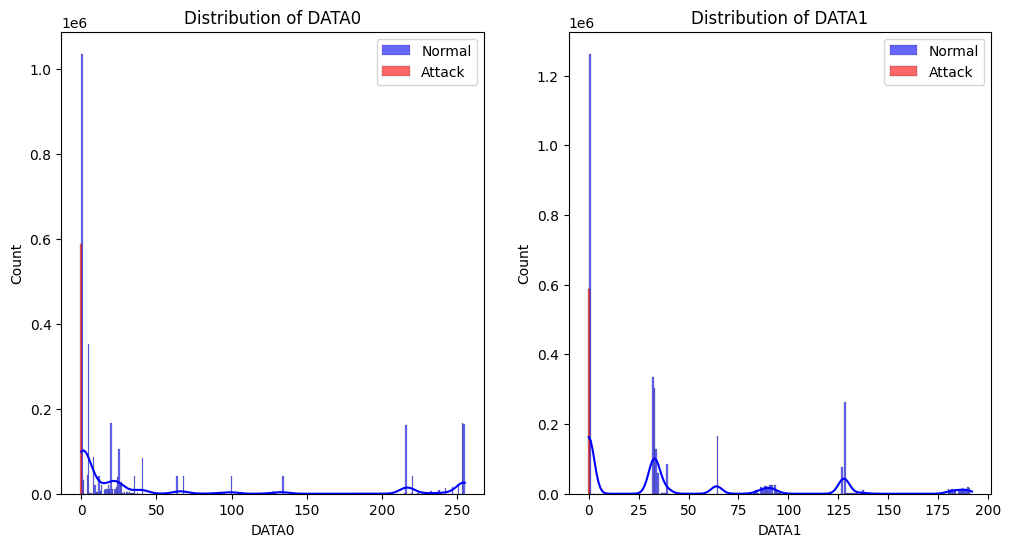

         DATA01 XOR    DATA01 SUM    DATA57 XOR
count  3.665770e+06  3.665770e+06  3.665770e+06
mean   6.466313e+01  8.795492e+01  8.055340e+01
std    7.747898e+01  1.136463e+02  8.581679e+01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    3.300000e+01  3.700000e+01  5.200000e+01
75%    1.280000e+02  1.440000e+02  1.540000e+02
max    2.550000e+02  4.120000e+02  2.550000e+02
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    615638
           1       0.87      1.00      0.93    117516

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154



In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import xgboost as xgb

# Load dataset
df = df_9.copy()
print(df.columns)


# Define feature columns and target
features = ['DATA0', 'DATA1', 'DATA5', 'DATA7']
X = df[features]
y = df['Flag']  # Target: 1 = Attack, 0 = Normal

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability scores

# Performance Metrics
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Precision-Recall Curve & Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
target_recall = 0.95
idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[idx]
print(f"Optimal Decision Threshold: {optimal_threshold:.2f}")

# Feature Importance Analysis
plt.figure(figsize=(8, 5))
xgb.plot_importance(model, importance_type='weight', title="Feature Importance")
plt.show()

# Byte-Level Analysis
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features[:2]):  # DATA0 and DATA1
    plt.subplot(1, 2, i + 1)
    sns.histplot(df[df['Flag'] == 0][feature], label='Normal', color='blue', kde=True, alpha=0.6)
    sns.histplot(df[df['Flag'] == 1][feature], label='Attack', color='red', kde=True, alpha=0.6)
    plt.title(f"Distribution of {feature}")
    plt.legend()

plt.show()

# Feature Engineering (Bitwise & Arithmetic Transformations)
df['DATA01 XOR'] = df['DATA0'] ^ df['DATA1']
df['DATA01 SUM'] = df['DATA0'] + df['DATA1']
df['DATA57 XOR'] = df['DATA5'] ^ df['DATA7']

print(df[['DATA01 XOR', 'DATA01 SUM', 'DATA57 XOR']].describe()) 

# Train again with engineered features
X_new = df[['DATA0', 'DATA1', 'DATA5', 'DATA7', 'DATA01 XOR', 'DATA01 SUM', 'DATA57 XOR']]
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
model.fit(X_train_new, y_train)

# Evaluate again
y_pred_new = model.predict(X_test_new)
print(classification_report(y_test, y_pred_new))


## Hyperparameter Tuning using GridSearchCV

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                           param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}


## Algorithm RF

Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


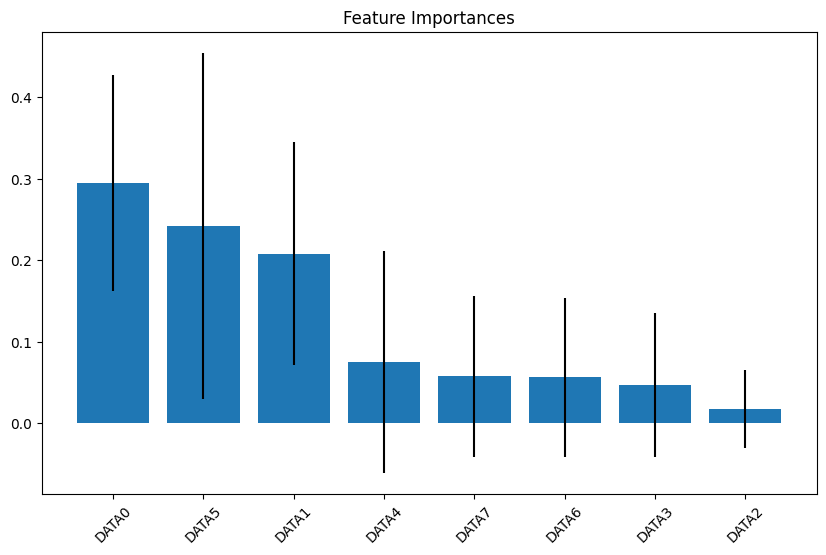

In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 2. Split data
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Initialize Random Forest with class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all cores
    random_state=42
)

# 4. Train model
rf.fit(X_train, y_train)

# 5. Evaluate
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 6. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.show()

## Class Weight Tuning

Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


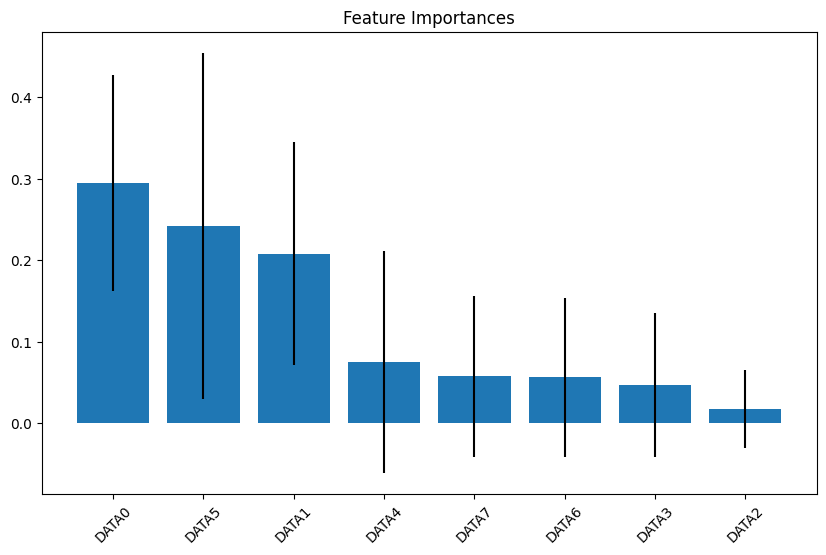

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


# 2. Split data
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Manually calculate class weights based on the exact class ratio (~5.24:1)
ratio = 3_078_250 / 587_521  # approximately 5.24
class_weights = {0: 1, 1: ratio}  # Assign higher weight to minority class

# 4. Initialize Random Forest with manually calculated class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # using manual weights instead of 'balanced'
    max_depth=10,                # Prevent overfitting
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# 5. Train the model
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame for feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.show()


## Threshold Adjustment

Optimal Threshold (based on maximum F1): 0.9726
Accuracy: 0.9766351953341317
Confusion Matrix:
 [[598520  17130]
 [     0 117504]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    615650
           1       0.87      1.00      0.93    117504

    accuracy                           0.98    733154
   macro avg       0.94      0.99      0.96    733154
weighted avg       0.98      0.98      0.98    733154


ROC AUC Score: 0.9861


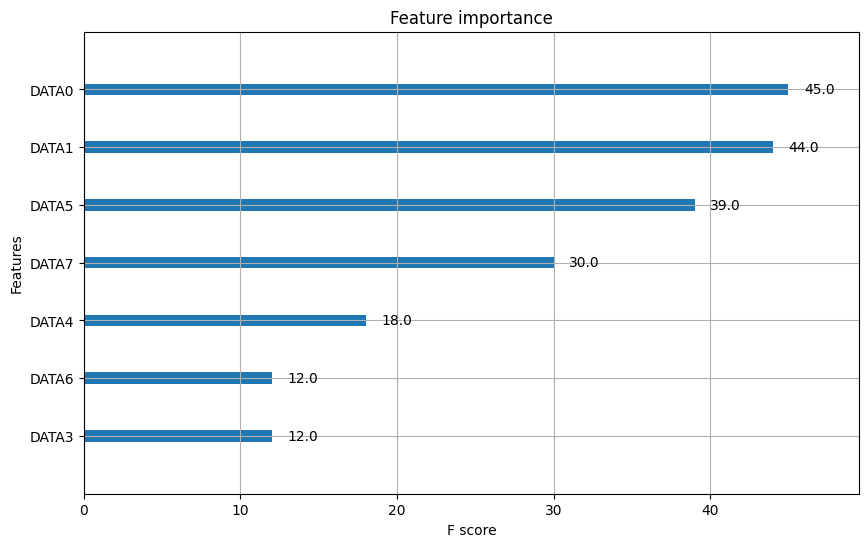

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost classifier with built-in imbalance handling
model = xgb.XGBClassifier(
    scale_pos_weight=5.24,      # Directly accounts for the class imbalance ratio
    objective='binary:logistic',
    eval_metric='aucpr',        # Optimize for precision-recall AUC
    use_label_encoder=False,    # Suppress a warning regarding label encoding
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# 7. Threshold Adjustment: Optimize decision threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for each threshold; note that thresholds array is one element shorter than precision/recall
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal Threshold (based on maximum F1): {best_threshold:.4f}")

# Use the optimal threshold to make final predictions
y_pred = (y_proba >= best_threshold).astype(int)

# 8. Evaluate the model with the adjusted threshold
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 9. Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
xgb.plot_importance(model, ax=plt.gca())
plt.show()


## Hyperparameter Tuning:

In [130]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_rf.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))


# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 200]
# }

# grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
#                            param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)


KeyboardInterrupt: 

2. **Advanced Handling of CAN ID**:

In [ ]:
   # Create interaction features between CAN ID and data bytes
   df['CAN_ID_Interaction'] = df['CAN ID'].astype(str) + '_' + df['DATA0'].astype(str)

3. **Dimensionality Reduction**:

In [ ]:
 from sklearn.decomposition import PCA
   
   pca = PCA(n_components=5)
   X_pca = pca.fit_transform(X)